In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from IPython import display
from tensorflow.data import Dataset

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Embedding, Reshape, Flatten, Dropout, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D, Concatenate
from tensorflow_addons.layers import SpectralNormalization

from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from utils import FrechetInceptionDistance

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

In [3]:
# set gpu memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
FILE_PATH = 'data\cifar10.tfrecords'
dataset = Dataset.load(FILE_PATH)
print(dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


In [5]:
def create_generator(latent_dim):
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    
    # linear activation
    label_embedding = Dense(4 * 4, name='label_dense')(label_embedding)

    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, name='noise_dense')(noise_input)
    noise_dense = ReLU(name='noise_relu')(noise_dense)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(noise_dense)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image to produce 129-channel output
    concat = Concatenate(name='concatenate')([noise_reshape, label_embedding])
    assert concat.shape == (None, 4, 4, 129)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    conv1 = ReLU(name='conv1_relu')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(conv1)
    assert conv2.shape == (None, 16, 16, 128)
    conv2 = ReLU(name='conv2_relu')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(conv2)
    assert conv3.shape == (None, 32, 32, 128)
    conv3 = ReLU(name='conv3_relu')(conv3)

    # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(conv3)
    assert output.shape == (None, 32, 32, 3)

    model = Model(inputs=[noise_input, label_input], outputs=output, name='generator')

    return model

In [6]:
def create_discriminator():
    input_layer = Input(shape=(32, 32, 3), name='image_input')

    # downsample to 16x16
    conv1 = SpectralNormalization(Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv1'))
    conv1 = conv1(input_layer)
    assert conv1.shape == (None, 16, 16, 128)
    conv1 = LeakyReLU(alpha=0.2, name='conv1_leaky_relu')(conv1)

    # downsample to 8x8
    conv2 = SpectralNormalization(Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv2'))
    conv2 = conv2(conv1)
    assert conv2.shape == (None, 8, 8, 128)
    conv2 = LeakyReLU(alpha=0.2, name='conv2_leaky_relu')(conv2)

    # downsample to 4x4
    conv3 = SpectralNormalization(Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv3'))
    conv3 = conv3(conv2)
    assert conv3.shape == (None, 4, 4, 128)
    conv3 = LeakyReLU(alpha=0.2, name='conv3_leaky_relu')(conv3)

    # flatten feature maps
    flat = Flatten(name='flatten')(conv3)

    # output layers
    sigmoid_out = Dense(units=1, activation='sigmoid', name='sigmoid_output')(flat)
    softmax_out = Dense(units=10, activation='softmax', name='softmax_output')(flat)

    model = Model(input_layer, [sigmoid_out, softmax_out], name='discriminator')

    return model

In [7]:
class ACGAN(Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(ACGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_1, loss_2):
        super(ACGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_1 = loss_1 # disc and gen loss
        self.loss_2 = loss_2 # auxiliary loss
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')  # disc bce loss
        self.aux_loss_metric = keras.metrics.Mean(name='aux_loss')  # disc cce loss
        self.d_acc_metric = keras.metrics.BinaryAccuracy(name='d_acc')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric, self.aux_loss_metric, self.d_acc_metric]

    def train_step(self, data):
        real_images, class_labels = data
        class_labels = tf.cast(class_labels, tf.float32)
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator([random_latent_vectors, class_labels], training=True)

        # freeze generator
        self.discriminator.trainable = True
        self.generator.trainable = False

        with tf.GradientTape() as disc_tape:
            real_pred, real_aux = self.discriminator(real_images, training=True)
            fake_pred, fake_aux = self.discriminator(generated_images, training=True)

            # discriminator loss
            d_loss_1 = self.loss_1(tf.ones_like(real_pred), real_pred)
            d_loss_2 = self.loss_1(tf.zeros_like(fake_pred), fake_pred)
            d_loss = d_loss_1 + d_loss_2
            # auxiliary loss
            aux_loss = self.loss_2(class_labels, fake_aux)
            # total discriminator loss
            d_loss += aux_loss

        # discriminator gradients
        d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
        # update discriminator
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

        # generator loss
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # freeze discriminator
        self.discriminator.trainable = False
        self.generator.trainable = True

        with tf.GradientTape() as gen_tape:
            generated_images = self.generator([random_latent_vectors, class_labels], training=True)
            fake_pred, fake_aux = self.discriminator(generated_images, training=True)
            g_loss_1 = self.loss_1(tf.ones_like(fake_pred), fake_pred)
            g_loss_2 = self.loss_2(class_labels, fake_aux)
            g_loss = g_loss_1 + g_loss_2

        # generator gradients
        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        # update generator
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        # update metrics
        self.g_loss_metric.update_state(g_loss)
        self.d_loss_metric.update_state(d_loss)
        self.aux_loss_metric.update_state(aux_loss)
        self.d_acc_metric.update_state(tf.ones_like(real_pred), real_pred)
        
        return {
            'g_loss': self.g_loss_metric.result(),
            'd_loss': self.d_loss_metric.result(),
            'aux_loss': self.aux_loss_metric.result(),
            'd_acc': self.d_acc_metric.result()
        }

In [8]:
class GANMonitor(Callback):
    def __init__(self, latent_dim, label_map):
        self.latent_dim = latent_dim
        self.label_map = label_map

    def on_epoch_end(self, epoch, logs=None):
        latent_vectors = tf.random.normal(shape=(100, self.latent_dim))
        class_labels = tf.reshape(tf.range(10), shape=(10, 1))
        class_labels = tf.tile(class_labels, multiples=(1, 10))
        class_labels = tf.reshape(class_labels, shape=(100, 1))

        generated_images = self.model.generator([latent_vectors, class_labels], training=False)
        generated_images = (generated_images + 1) / 2

        if not os.path.exists('images/acgan_images'):
            os.makedirs('images/acgan_images')

        if (epoch) % 10 == 0:
            fig, axes = plt.subplots(10, 10, figsize=(20, 20))
            axes = axes.flatten()

            for i, ax in enumerate(axes):
                ax.imshow(generated_images[i])
                ax.set_title(self.label_map[class_labels[i].numpy().item()], fontsize=16)
                ax.axis('off')

            plt.tight_layout()
            plt.savefig(f'images/acgan_images/generated_img_{epoch + 1}.png')
            plt.close()

In [9]:
EPOCHS = 1000
LATENT_DIM = 128    
LEARNING_RATE = 2e-4
BETA_1 = 0.5
LABEL_SMOOTHING = 0.1

label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

callbacks = [GANMonitor(LATENT_DIM, label_map)]

generator = create_generator(LATENT_DIM)
discriminator = create_discriminator()
acgan = ACGAN(generator, discriminator, latent_dim=LATENT_DIM)
acgan.compile(
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1),
    loss_1=BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    loss_2=SparseCategoricalCrossentropy()
)

In [10]:
%%time
history = acgan.fit(dataset, epochs=EPOCHS, callbacks=callbacks, use_multiprocessing=True)

Epoch 1/1000
467/467 [==============================] - 83s 98ms/step - g_loss: 4.1556 - d_loss: 3.1416 - aux_loss: 2.3058 - d_acc: 0.8711
Epoch 2/1000
467/467 [==============================] - 37s 80ms/step - g_loss: 4.0416 - d_loss: 3.2139 - aux_loss: 2.3067 - d_acc: 0.7794
Epoch 3/1000
467/467 [==============================] - 36s 77ms/step - g_loss: 2.6050 - d_loss: 2.3131 - aux_loss: 1.2196 - d_acc: 0.7293
Epoch 4/1000
467/467 [==============================] - 36s 78ms/step - g_loss: 1.2696 - d_loss: 1.1331 - aux_loss: 0.0390 - d_acc: 0.7265
Epoch 5/1000
467/467 [==============================] - 37s 80ms/step - g_loss: 1.1337 - d_loss: 1.1858 - aux_loss: 0.0178 - d_acc: 0.7028
Epoch 6/1000
467/467 [==============================] - 37s 80ms/step - g_loss: 1.0644 - d_loss: 1.2111 - aux_loss: 0.0155 - d_acc: 0.7092
Epoch 7/1000
467/467 [==============================] - 37s 79ms/step - g_loss: 1.0181 - d_loss: 1.2452 - aux_loss: 0.0116 - d_acc: 0.6692
Epoch 8/1000
467/467 [=====

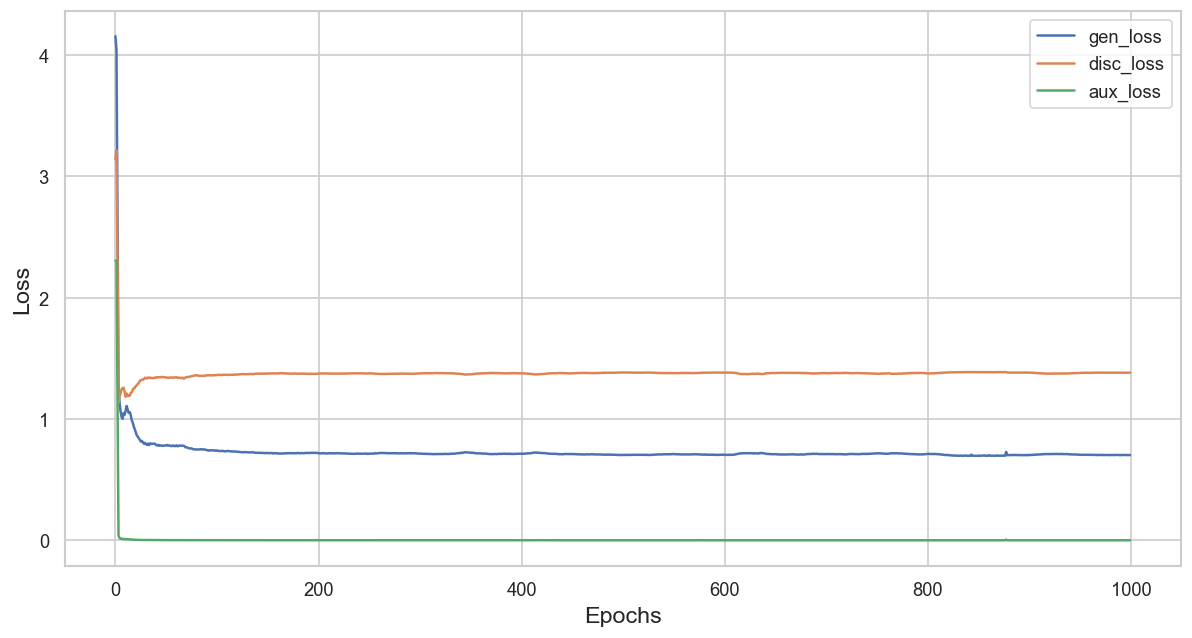

In [11]:
plt.figure(figsize=(12,6))

plt.plot(history.history['g_loss'], label='gen_loss')
plt.plot(history.history['d_loss'], label='disc_loss')
plt.plot(history.history['aux_loss'], label='aux_loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()
plt.show() 

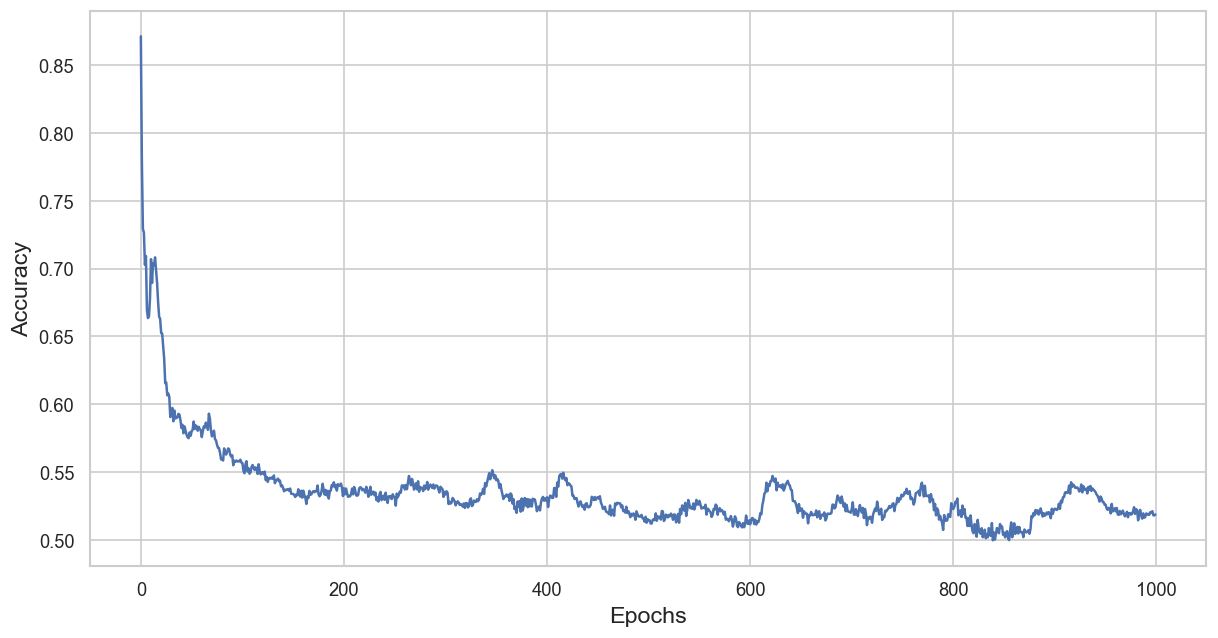

In [12]:
plt.figure(figsize=(12,6))
plt.plot(history.history['d_acc'], label='disc_acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.show()

In [14]:
latent_vectors = tf.random.normal(shape=(100, LATENT_DIM))
class_labels = tf.reshape(tf.range(10), shape=(10, 1))
class_labels = tf.tile(class_labels, multiples=(1, 10))
class_labels = tf.reshape(class_labels, shape=(100, 1))

generated_images = acgan.generator([latent_vectors, class_labels], training=False)
generated_images = (generated_images + 1) / 2

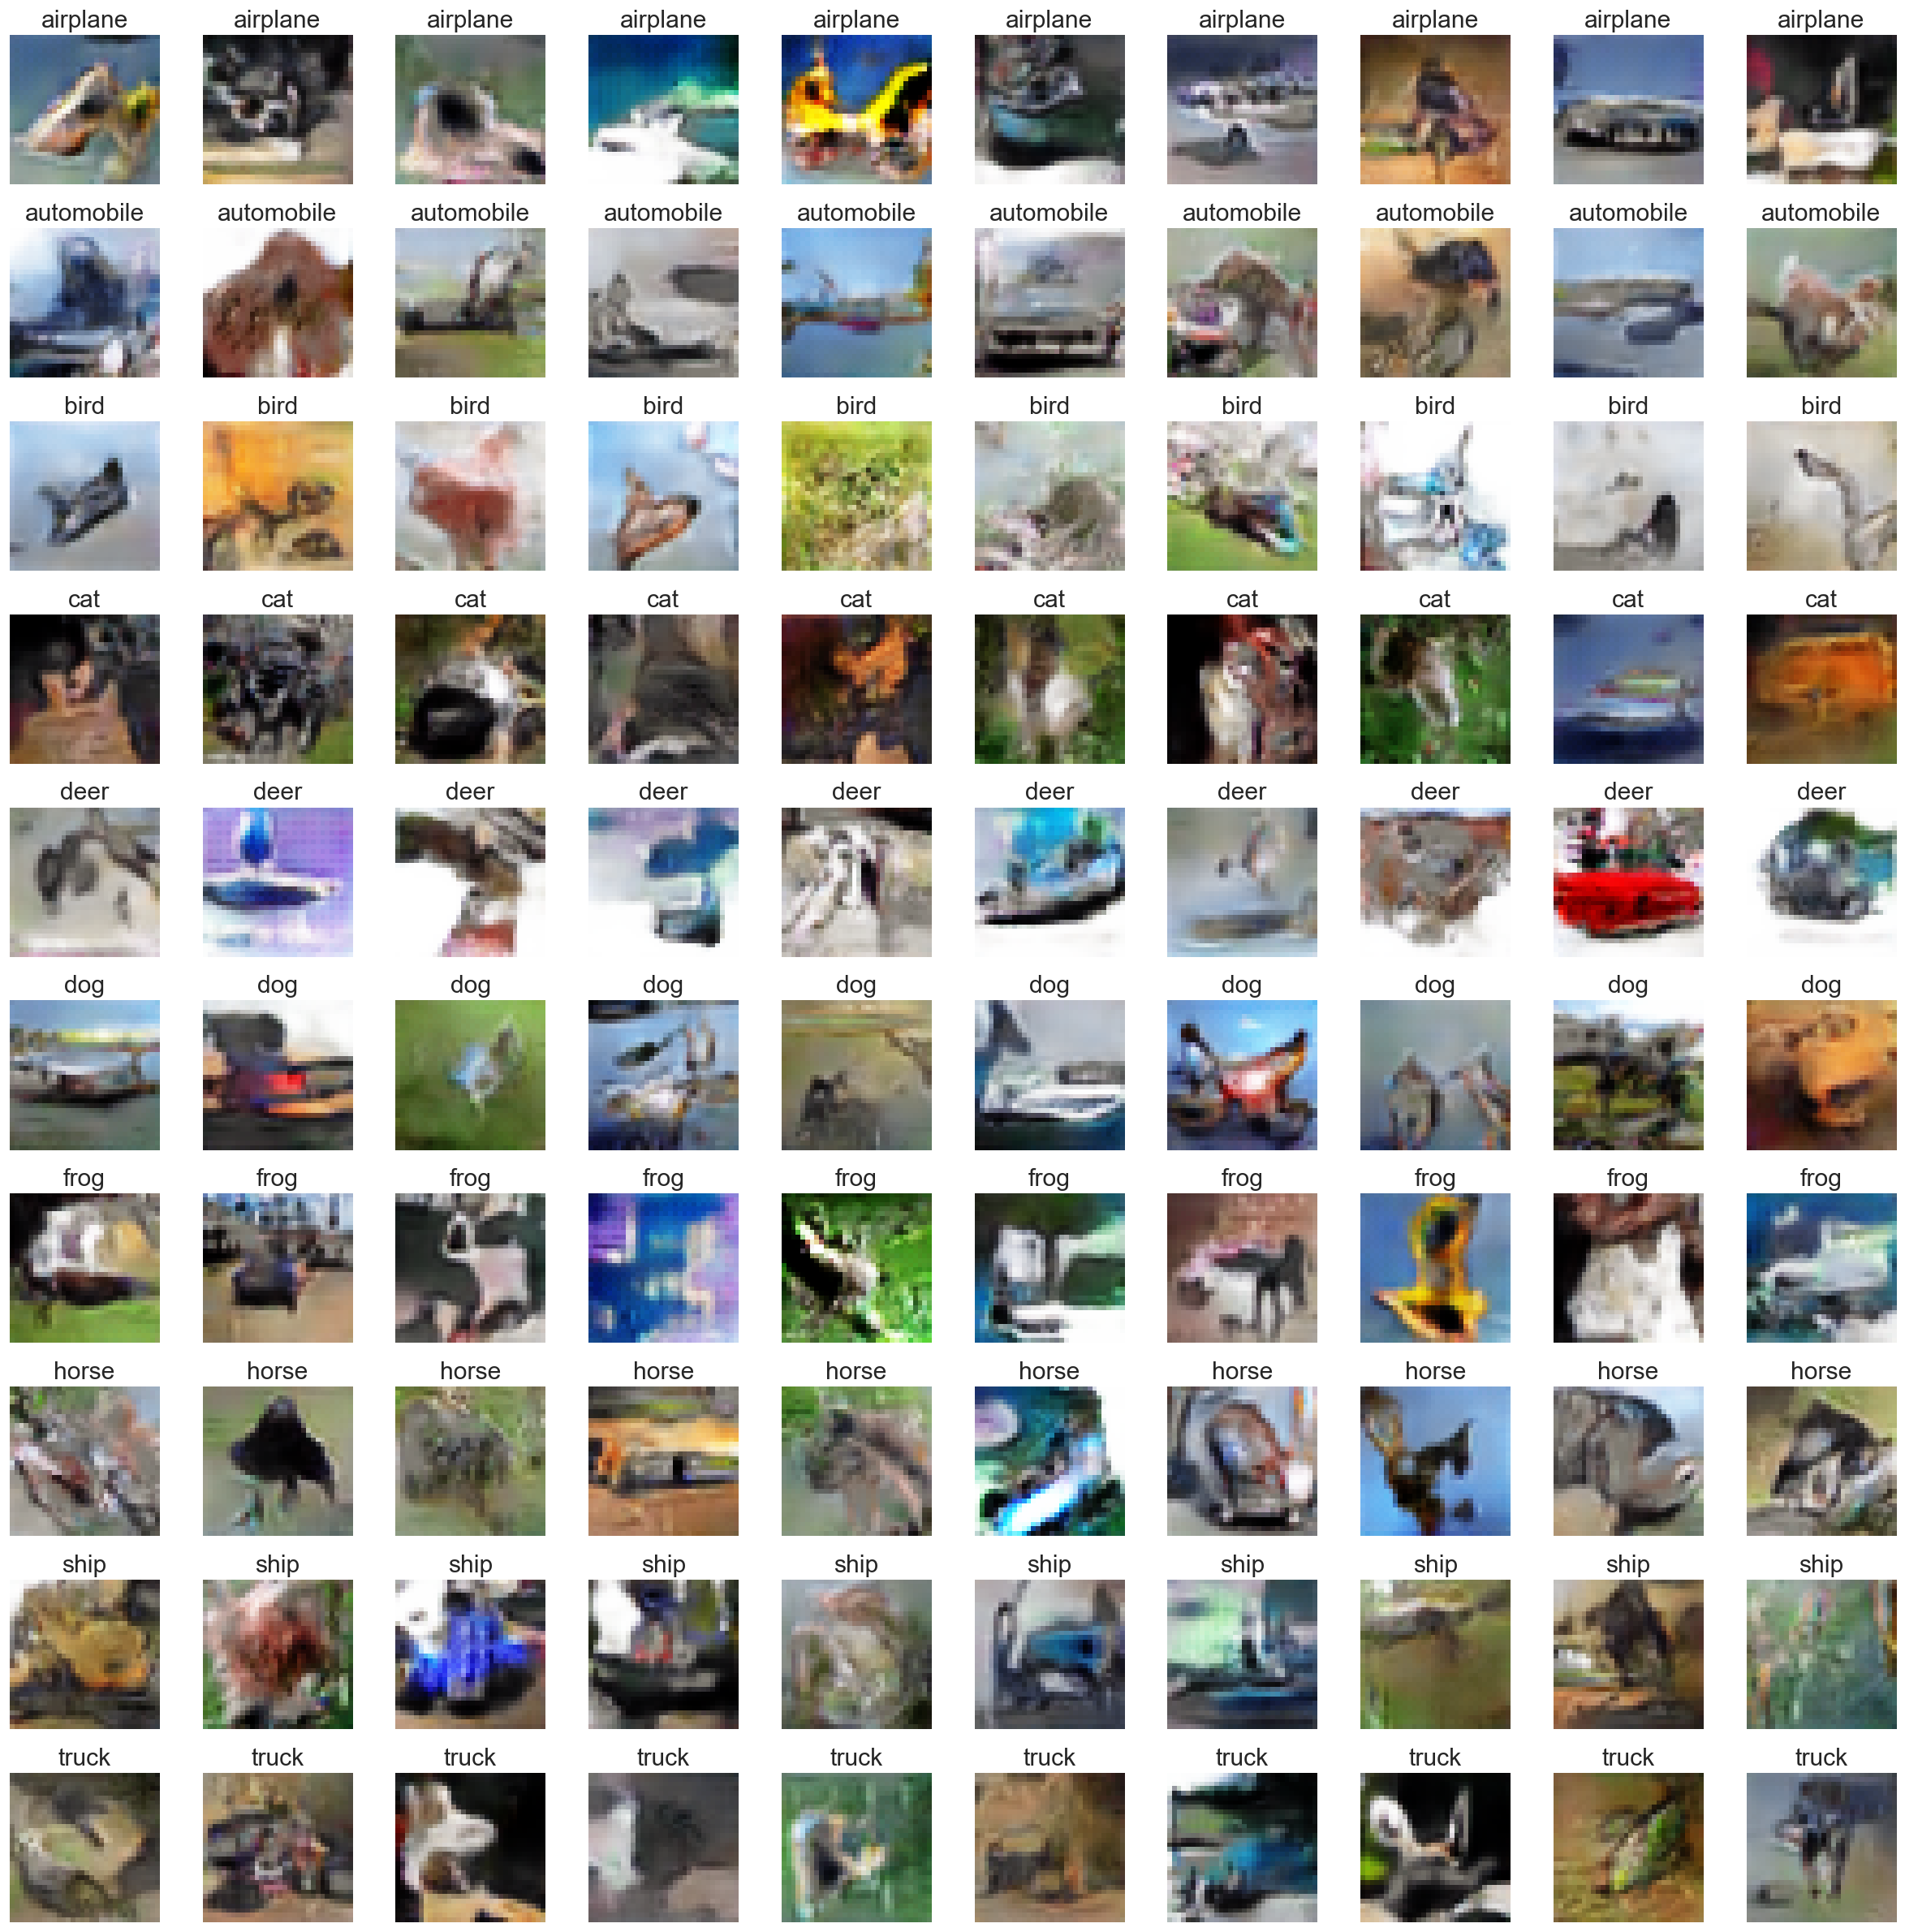

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.set_title(label_map[class_labels[i].numpy().item()], fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()